- hacim tahminleme
    - klasik model
        - diğer featurelar
                - ek veri
                    - enflasyon
                    - döviz
                    - üfe
                    - holiday dataset
          
                - order day/week/month
                - sipariş verme sıklığı
                - daily_average
                - ürün bazlı sipariş verme sıklığı
                - day diff between last order
    - past data based model
        - convert sales to daily basis
        - geçmiş 10/20/30/40/50/60/90 gün verisi
    - rnn
    - lstm

trials
    - sum of past data
    - average of past data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
order_df = pd.read_csv('datathon_order.csv', parse_dates=['Sipariş Tarihi'])

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
order_df.columns = ['order_num', 'order_item', 'order_type', 'material_num', 'order_amount', 
                    'palette_std', 'customer_num', 'order_date', 'operation_type']

In [4]:
def convert_string_to_date(str_date):
    
    str_date = str(str_date)
    str_date = str_date.replace('/','')
    str_date = str_date.replace('.','')
    
    len_date = len(str_date)
    
    if len_date>7:
        return pd.Timestamp(int(str_date[4:]), int(str_date[2:4]), int(str_date[:2]))   
    elif len_date==7:
        return pd.Timestamp(int(str_date[3:]), int(str_date[1:3]), int(str_date[:1]))   
    elif len_date==6:
        return pd.Timestamp(int(str_date[2:]), int(str_date[1:2]), int(str_date[:1]))   

In [5]:
order_df['order_item'] = order_df['order_item'].fillna(0)

In [6]:
order_df.head()

,order_num,order_item,order_type,material_num,order_amount,palette_std,customer_num,order_date,operation_type
0,72616887,1.0,20.0,61001960,60,228.0,C-10008,2020-01-02,O1
1,72616888,1.0,20.0,61000066,25,96.0,C-10185,2020-01-02,O1
2,72616888,2.0,20.0,61001960,50,228.0,C-10185,2020-01-02,O1
3,72616889,1.0,20.0,61000066,40,96.0,C-10188,2020-01-02,O1
4,72616889,2.0,20.0,61001960,20,228.0,C-10188,2020-01-02,O1


In [7]:
# from analysis we saw that customer number 'C-10170' is replaced with 'C-10277', so we replace all the values
order_df.replace('C-10170', 'C-10277', inplace=True)

In [8]:
order_df.isna().sum()

order_num           0
order_item          0
order_type         12
material_num        0
order_amount        0
palette_std       935
customer_num        0
order_date          0
operation_type      0
dtype: int64

In [9]:
for col in order_df.columns:
    print(f'# of unique values in {col} : {order_df[col].nunique()}')

# of unique values in order_num : 107818
# of unique values in order_item : 180
# of unique values in order_type : 4
# of unique values in material_num : 807
# of unique values in order_amount : 1243
# of unique values in palette_std : 119
# of unique values in customer_num : 670
# of unique values in order_date : 319
# of unique values in operation_type : 2


In [10]:
order_df.describe()

,order_item,order_type,order_amount,palette_std
count,508069.000000,508057.000000,508069.000000,507134.000000
mean,84.641246,23.346219,29.491608,141.264522
std,608.656683,7.680965,118.890148,86.014738
min,0.000000,10.000000,1.000000,1.000000
25%,8.000000,20.000000,2.000000,80.000000
50%,20.000000,20.000000,5.000000,99.000000
75%,50.000000,20.000000,20.000000,216.000000
max,9999.000000,40.000000,21000.000000,650.000000


In [11]:
raw_df = order_df.copy()

In [12]:
# grouping data by order_date, same products may be placed with different orders in same day
order_df = order_df.groupby(['order_date', 'material_num', 'customer_num']).agg(
                                           {'order_item':'count', 'order_type':'max', 
                                            'order_amount':'sum', 'palette_std':'max',
                                            'operation_type':'max', 'order_num':'count'}).reset_index()

In [13]:
order_df['order_weekday'] =  pd.to_datetime(order_df['order_date']).dt.weekday
order_df['order_month'] = pd.to_datetime(order_df['order_date']).dt.month
order_df['order_day'] = pd.to_datetime(order_df['order_date']).dt.day
order_df['order_week'] = pd.to_datetime(order_df['order_date']).dt.week

<ipython-input-13-8cc37f26546a>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_df['order_week'] = pd.to_datetime(order_df['order_date']).dt.week


In [14]:
order_df['order_num'] = order_df['order_num'].astype('int16')
order_df['order_item'] = order_df['order_item'].astype('int16')
order_df['material_num'] = order_df['material_num'].astype('str')
order_df['order_amount'] = order_df['order_amount'].astype('int32')

order_df['order_type'] = order_df['order_type'].astype('category')
order_df['palette_std'] = order_df['palette_std'].astype('category')
order_df['customer_num'] = order_df['customer_num'].astype('category')
order_df['operation_type'] = order_df['operation_type'].astype('category')

In [15]:
order_df.columns

Index(['order_date', 'material_num', 'customer_num', 'order_item',
       'order_type', 'order_amount', 'palette_std', 'operation_type',
       'order_num', 'order_weekday', 'order_month', 'order_day', 'order_week'],
      dtype='object')

In [16]:
order_df.groupby(['material_num'])['order_amount'].sum().nlargest(10)

material_num
4016984     458685
61001960    368298
4002326     352764
4002329     344800
4047491     228728
TR01822B    222226
TR01575A    203860
4050584     195385
PL08105A    189395
TR02288A    172344
Name: order_amount, dtype: int32

In [17]:
order_df.groupby(['material_num'])['order_amount'].sum().nsmallest(10)

material_num
4253047     1
669690      1
669719      1
CN00912A    1
PL03154A    1
TR00191B    1
TR01657A    1
TR01659A    1
4253046     2
61008454    2
Name: order_amount, dtype: int32

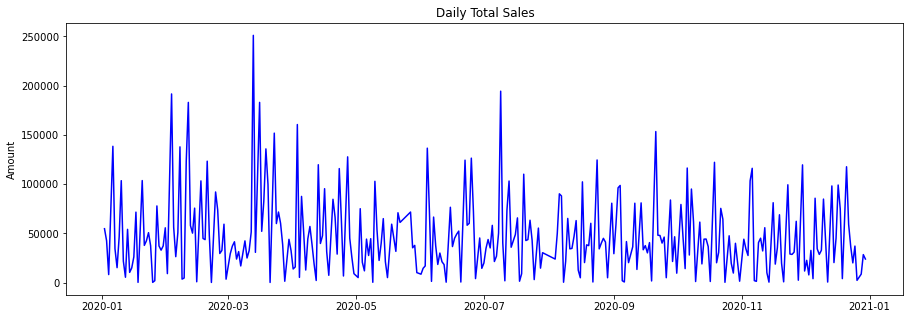

In [18]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_summary.index, order_summary.values, 'b')
plt.title('Daily Total Sales')
plt.ylabel('Amount')
plt.show();

when we analyze the daily total sales, dataset looks like stationary whihch does not have any trend or seasonality

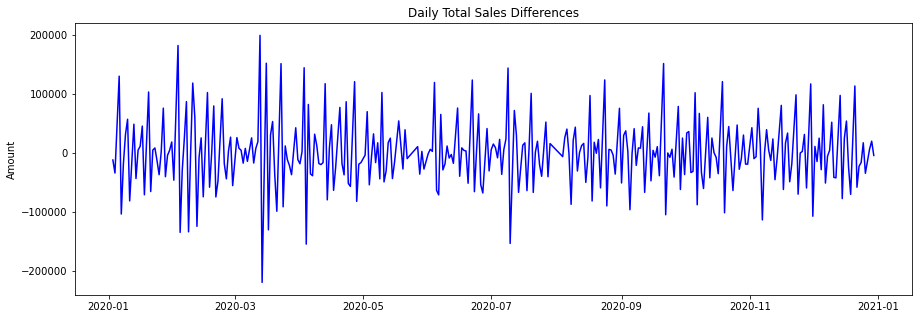

In [19]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
daily_diff = order_summary-order_summary.shift(1)
plt.figure(figsize=(15,5))
plt.plot(daily_diff.index, daily_diff.values, 'b')
plt.title('Daily Total Sales Differences')
plt.ylabel('Amount')
plt.show();

In [20]:
from statsmodels.tsa.stattools import adfuller
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
adf_result = adfuller(order_summary)
print(adf_result)

(-6.3212587878894935, 3.062149764735855e-08, 6, 312, {'1%': -3.4514843502727306, '5%': -2.8708485956333556, '10%': -2.571729625657462}, 7209.103604799183)


p value is less than 0.05 we reject the H0 hypothesis, meaning our data is stationary

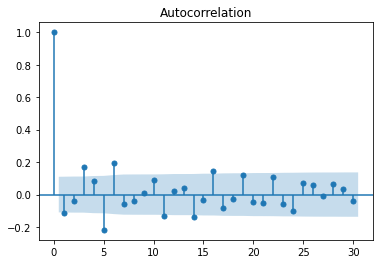

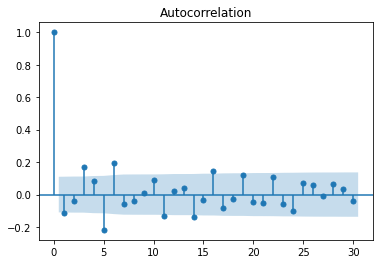

In [21]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(order_summary, lags=30)

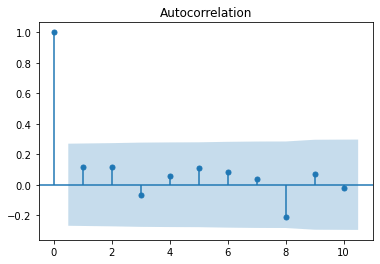

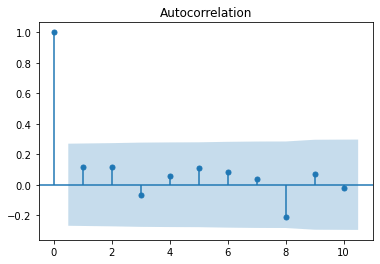

In [22]:
order_summary = order_df.groupby(['order_week'])['order_amount'].sum()
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(order_summary, lags=10)

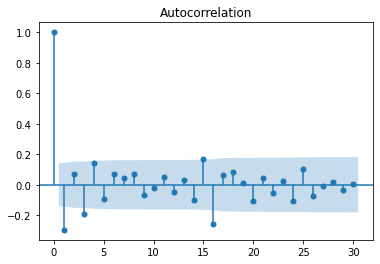

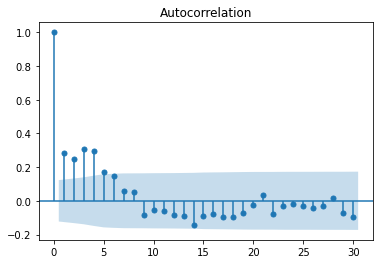

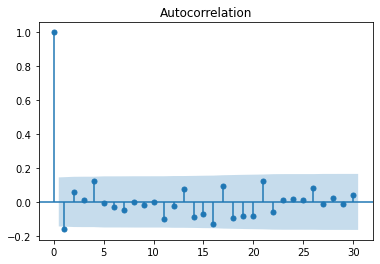

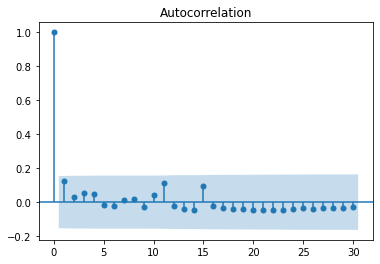

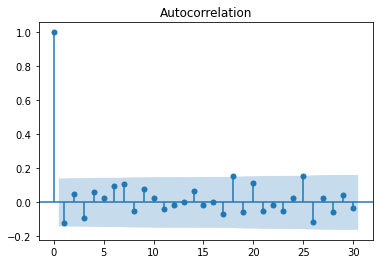

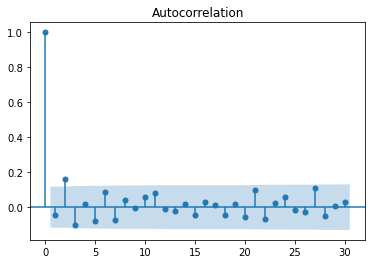

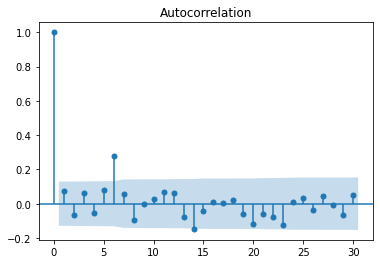

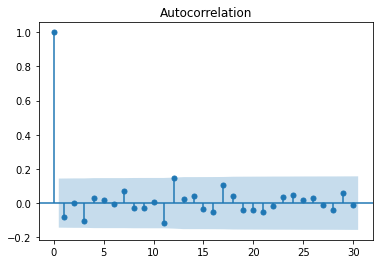

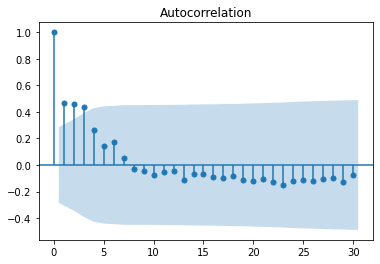

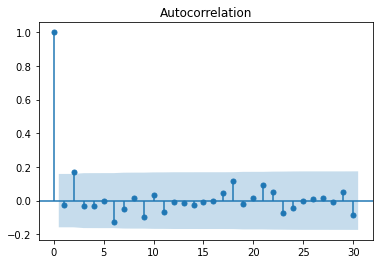

In [23]:
for material in order_df.groupby(['material_num'])['order_amount'].sum().nlargest(10).index:
    
    mat_orders = order_df[order_df['material_num']==material].groupby(['order_date'])['order_amount'].sum()
    
    plot_acf(mat_orders, lags=30)

<ipython-input-24-a8def2750e91>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_summary = order_df.groupby(order_df['order_date'].dt.week)['order_amount'].sum()


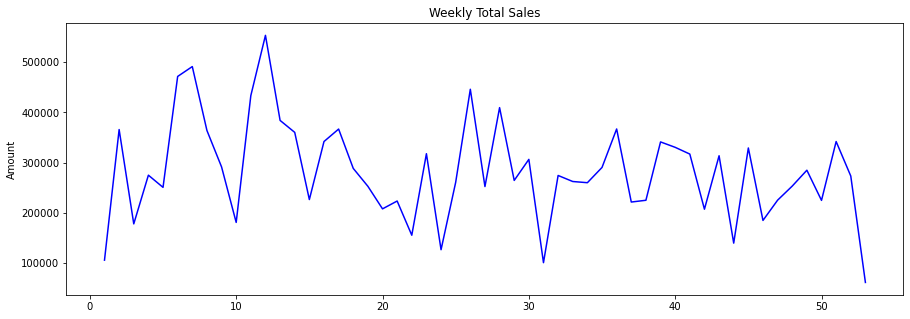

In [24]:
order_summary = order_df.groupby(order_df['order_date'].dt.week)['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_summary.index, order_summary.values, 'b')
plt.title('Weekly Total Sales')
plt.ylabel('Amount')
plt.show();

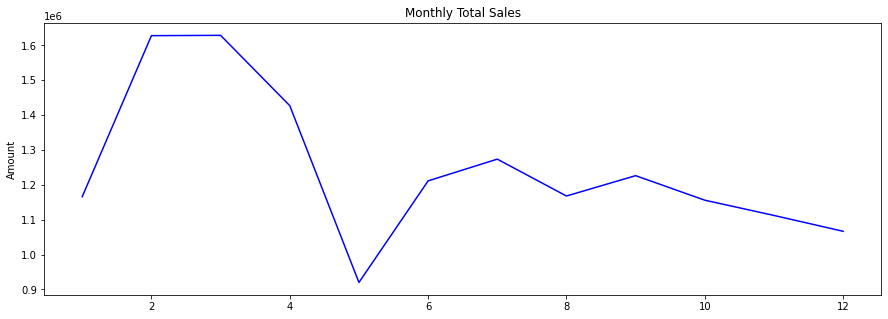

In [25]:
order_summary = order_df.groupby(order_df['order_date'].dt.month)['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_summary.index, order_summary.values, 'b')
plt.title('Monthly Total Sales')
plt.ylabel('Amount')
plt.show();

when we look at the weekly and monthly sales there is an increase in 2-4 months

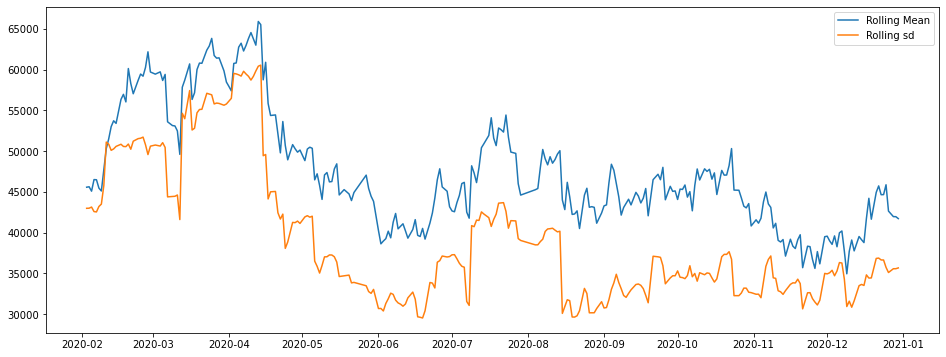

In [26]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
plt.figure(figsize=(16,6))
plt.plot(order_summary.rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(order_summary.rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();

<ipython-input-27-49ffc4d2bd6d>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_summary = order_df.groupby(order_df['order_date'].dt.week)['order_amount'].sum()


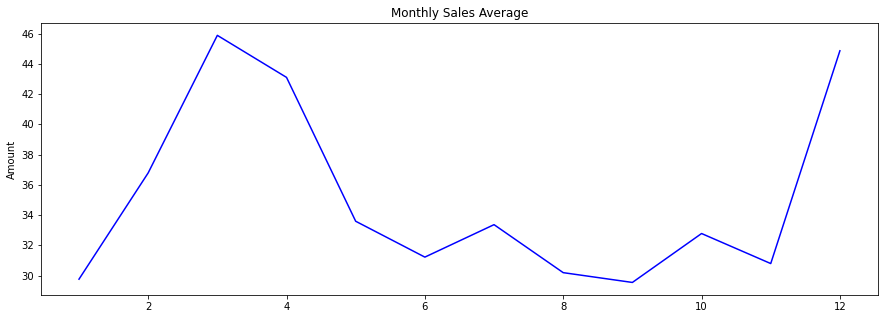

In [27]:
order_avgs = order_df.groupby(['order_month']).agg(order_count = ('order_amount', 'count'),
                                                   order_sum = ('order_amount', 'sum')).reset_index()

order_avgs['avg_monthly_order_amounts'] = order_avgs['order_sum']/order_avgs['order_count']

order_summary = order_df.groupby(order_df['order_date'].dt.week)['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_avgs['order_month'], order_avgs['avg_monthly_order_amounts'], 'b')
plt.title('Monthly Sales Average')
plt.ylabel('Amount')
plt.show();

<AxesSubplot:>

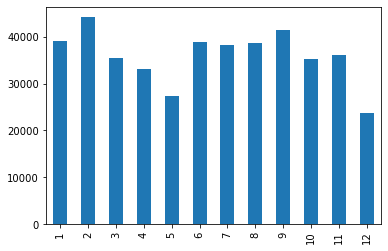

In [28]:
order_df['order_month'].value_counts().sort_index().plot(kind='bar')

In [29]:
order_df.groupby(['order_type'])['order_amount'].sum()

order_type
10.0    1260006
20.0    9995657
30.0      59118
40.0    3668204
Name: order_amount, dtype: int32

<AxesSubplot:xlabel='material_num'>

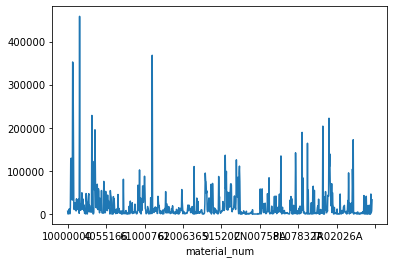

In [30]:
order_df.groupby(['material_num'])['order_amount'].sum().plot()

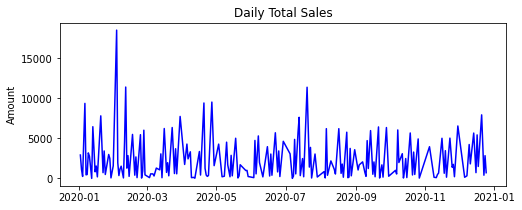

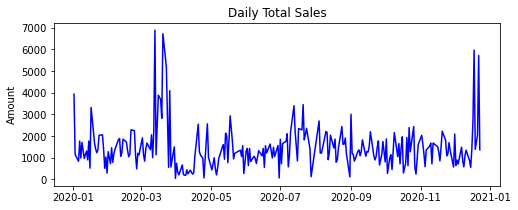

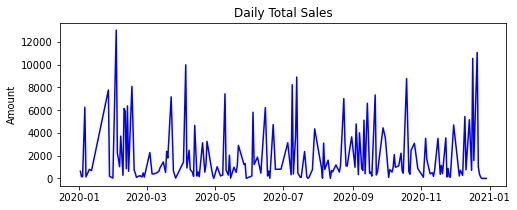

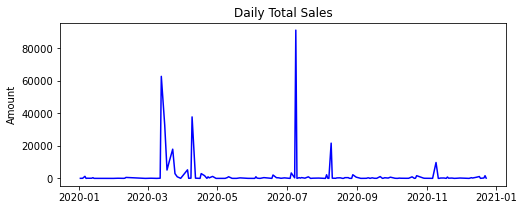

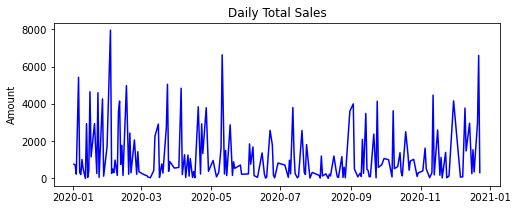

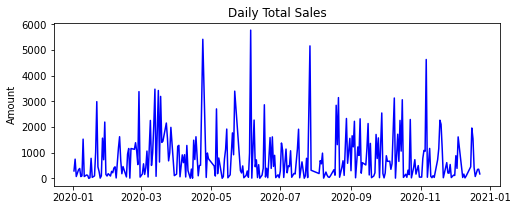

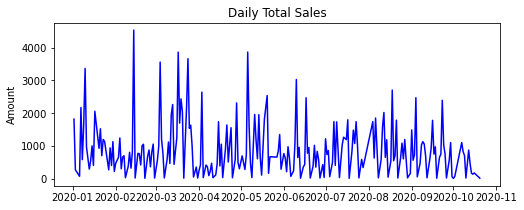

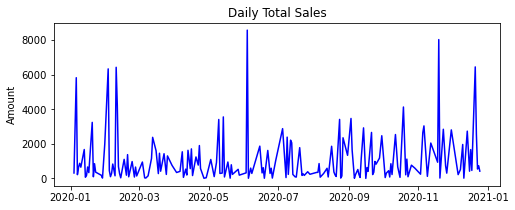

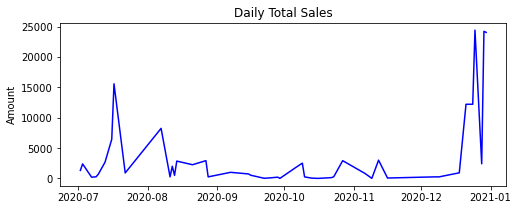

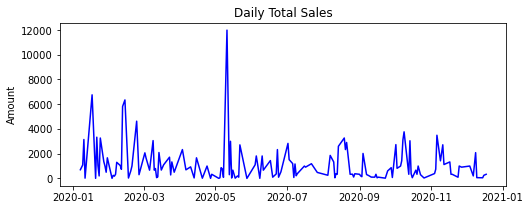

In [31]:
# daily sales for top 10 materials

for material in order_df.groupby(['material_num'])['order_amount'].sum().nlargest(10).index:
    
    mat_orders = order_df[order_df['material_num']==material].groupby(['order_date'])['order_amount'].sum()
    
    plt.figure(figsize=(8,3))
    plt.plot(mat_orders.index, mat_orders.values, 'b')
    plt.title('Daily Total Sales')
    plt.ylabel('Amount')
    plt.show();

our data looks stationary, so it is not possible to predict the future sales by only past data. There is a need to create some complex features to increase model performance

In [32]:
order_df.head(3)

,order_date,material_num,customer_num,order_item,order_type,order_amount,palette_std,operation_type,order_num,order_weekday,order_month,order_day,order_week
0,2020-01-02,91704,M10227,1,20.0,1,80.0,O2,1,3,1,2,1
1,2020-01-02,91704,M10229,1,20.0,2,80.0,O2,1,3,1,2,1
2,2020-01-02,91704,M10232,1,20.0,2,80.0,O2,1,3,1,2,1


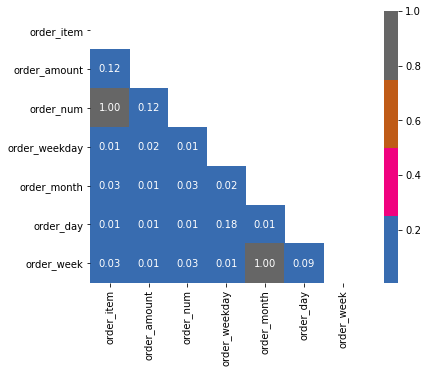

In [33]:
matrix = order_df.corr().abs()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
plt.figure(figsize=(8, 5))
sns.heatmap(matrix, mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap='Accent')

plt.show();

In [34]:
order_df.dtypes

order_date        datetime64[ns]
material_num              object
customer_num            category
order_item                 int16
order_type              category
order_amount               int32
palette_std             category
operation_type          category
order_num                  int16
order_weekday              int64
order_month                int64
order_day                  int64
order_week                 int64
dtype: object

# classical methods

### feature engineering

In [35]:
order_df.head()

,order_date,material_num,customer_num,order_item,order_type,order_amount,palette_std,operation_type,order_num,order_weekday,order_month,order_day,order_week
0,2020-01-02,91704,M10227,1,20.0,1,80.0,O2,1,3,1,2,1
1,2020-01-02,91704,M10229,1,20.0,2,80.0,O2,1,3,1,2,1
2,2020-01-02,91704,M10232,1,20.0,2,80.0,O2,1,3,1,2,1
3,2020-01-02,91704,M10234,1,20.0,1,80.0,O2,1,3,1,2,1
4,2020-01-02,91704,M10235,1,20.0,3,80.0,O2,1,3,1,2,1


In [36]:
order_df.shape

(431786, 13)

### ürün ve müşteri bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler

In [37]:
daily_order_amounts = order_df[['customer_num', 'material_num','order_date', 'order_amount']].copy()

results_by_mat_cust = pd.DataFrame()

for cust_key in daily_order_amounts['customer_num'].unique():
    
    cust_tmp_df = daily_order_amounts[daily_order_amounts['customer_num']==cust_key].drop('customer_num', axis=1)
    
    for material in cust_tmp_df['material_num'].unique():
        
        tmp_df = cust_tmp_df[cust_tmp_df['material_num']==material].drop('material_num', axis=1).set_index('order_date')
        
        current_day_orders = np.atleast_2d(tmp_df['order_amount'].values).T
        
        rolling_df = tmp_df.copy()
        rolling_df['customer_num'] = cust_key
        rolling_df['material_num'] = material

        for day_num in [2, 3, 5, 7, 10, 14, 30]:

            col_name = 'cust_mat_last_' + str(day_num) + '_day_sum'

            rolling_df[col_name] = tmp_df.rolling(str(day_num)+'d').sum().values - current_day_orders
        
        results_by_mat_cust = pd.concat([results_by_mat_cust, rolling_df.reset_index()], axis=0).reset_index(drop=True)

### ürün bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler - product economy

In [38]:
daily_order_amounts = order_df.groupby(['material_num','order_date'])['order_amount'].sum().reset_index()

results_by_mat = pd.DataFrame()

    
for material in daily_order_amounts['material_num'].unique():

    tmp_df = daily_order_amounts[daily_order_amounts['material_num']==material].drop('material_num', axis=1).set_index('order_date')

    current_day_orders = np.atleast_2d(tmp_df['order_amount'].values).T

    rolling_df = tmp_df.copy()
    rolling_df['material_num'] = material

    for day_num in [2, 3, 5, 7, 10, 14, 30]:

        col_name = 'material_last_' + str(day_num) + '_day_sum'

        rolling_df[col_name] = tmp_df.rolling(str(day_num)+'d').sum().values - current_day_orders

    results_by_mat = pd.concat([results_by_mat, rolling_df.reset_index()], axis=0).reset_index(drop=True)

### müşteri bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler - customer economy

In [39]:
daily_order_amounts = order_df.groupby(['customer_num', 'order_date'])['order_amount'].sum().reset_index()

results_by_cust = pd.DataFrame()

for cust_key in daily_order_amounts['customer_num'].unique():
    
    tmp_df = daily_order_amounts[daily_order_amounts['customer_num']==cust_key].drop('customer_num', axis=1).set_index('order_date')
         
    current_day_orders = np.atleast_2d(tmp_df['order_amount'].values).T

    rolling_df = tmp_df.copy()
    rolling_df['customer_num'] = cust_key

    for day_num in [2, 3, 5, 7, 10, 14, 30]:

        col_name = 'customer_last_' + str(day_num) + '_day_sum'

        rolling_df[col_name] = tmp_df.rolling(str(day_num)+'d').sum().values - current_day_orders

    results_by_cust = pd.concat([results_by_cust, rolling_df.reset_index()], axis=0).reset_index(drop=True)

### toplam geçmiş 1,2,3,5,7,14,30 günlük toplam siparişler - whole economy

In [40]:
daily_order_amounts = pd.DataFrame(order_df.groupby(['order_date'])['order_amount'].sum())

results_whole = pd.DataFrame()

current_day_orders = np.atleast_2d(daily_order_amounts['order_amount'].values).T

rolling_df = daily_order_amounts.copy()

for day_num in [2, 3, 5, 7, 10, 14, 30]:

    col_name = 'whole_last_' + str(day_num) + '_day_sum'

    rolling_df[col_name] = daily_order_amounts.rolling(str(day_num)+'d').sum().values - current_day_orders

results_whole = pd.concat([results_whole, rolling_df.reset_index()], axis=0).reset_index(drop=True)

In [41]:
order_df = pd.merge(order_df, results_by_mat_cust.drop('order_amount', axis=1), 
                    on=['order_date', 'customer_num', 'material_num'], how='left')
order_df = pd.merge(order_df, results_by_cust.drop('order_amount', axis=1), 
                    on=['order_date', 'customer_num'], how='left')
order_df = pd.merge(order_df, results_by_mat.drop('order_amount', axis=1), 
                    on=['order_date', 'material_num'], how='left')
order_df = pd.merge(order_df, results_whole.drop('order_amount', axis=1), 
                    on=['order_date'], how='left')

In [42]:
order_df.dtypes

order_date                  datetime64[ns]
material_num                        object
customer_num                        object
order_item                           int16
order_type                        category
order_amount                         int32
palette_std                       category
operation_type                    category
order_num                            int16
order_weekday                        int64
order_month                          int64
order_day                            int64
order_week                           int64
cust_mat_last_2_day_sum            float64
cust_mat_last_3_day_sum            float64
cust_mat_last_5_day_sum            float64
cust_mat_last_7_day_sum            float64
cust_mat_last_10_day_sum           float64
cust_mat_last_14_day_sum           float64
cust_mat_last_30_day_sum           float64
customer_last_2_day_sum            float64
customer_last_3_day_sum            float64
customer_last_5_day_sum            float64
customer_la

In [43]:
order_df.to_csv('order_v1.csv', index=False)

In [44]:
stop

NameError: name 'stop' is not defined

### additional datasets

In [ ]:
dates20 = pd.DataFrame(pd.date_range(start='01-01-2020', end='30-12-2020'), columns=['date'])
dates21 = pd.DataFrame(pd.date_range(start='01-01-2021', end='30-11-2021'), columns=['date'])

In [ ]:
currency_21 = pd.read_excel('currency_21.xlsx', parse_dates=['date'])
currency_21.fillna(method='ffill', inplace=True)
currency_21 = pd.merge(dates21, currency_21, on=['date'], how='left')

In [ ]:
holidays_21 = pd.read_excel('holidays_21.xlsx', parse_dates=['date'])
holidays_21 = pd.merge(dates21, holidays_21, on=['date'], how='left')
holidays_21.fillna(1.0, inplace=True)

In [ ]:
tufe_21 = pd.read_excel('tufe_21.xlsx', parse_dates=['date'])
tufe_21 = pd.merge(dates21, tufe_21, on=['date'], how='left')
tufe_21.fillna(method='ffill', inplace=True)

In [ ]:
tüfe ve üfe için artış oranını hesapla

In [ ]:
ufe_21 = pd.read_excel('ufe_21.xlsx', parse_dates=['date'])
ufe_21 = pd.merge(dates21, ufe_21, on=['date'], how='left')
ufe_21.fillna(method='ffill', inplace=True)

In [ ]:
ufe_21 = pd.read_excel('ufe_21.xlsx', parse_dates=['date'])

In [ ]:
ufe_21.head()

In [ ]:
order_df ile birleştir

In [ ]:
order_df

In [ ]:
drops = ['order_date', 'order_item', 'order_type', 'operation_type', 'palette_std','order_num']
categorical = ['material_num', 'customer_num','order_weekday', 'order_month', 'order_day', 'order_week']
numerical = ['cust_mat_last_2_day_sum', 'cust_mat_last_3_day_sum', 'cust_mat_last_5_day_sum', 'cust_mat_last_7_day_sum',
               'cust_mat_last_10_day_sum', 'cust_mat_last_14_day_sum', 'cust_mat_last_30_day_sum', 'customer_last_2_day_sum',
               'customer_last_3_day_sum', 'customer_last_5_day_sum', 'customer_last_7_day_sum', 'customer_last_10_day_sum',
               'customer_last_14_day_sum', 'customer_last_30_day_sum', 'material_last_2_day_sum', 'material_last_3_day_sum',
               'material_last_5_day_sum', 'material_last_7_day_sum', 'material_last_10_day_sum', 'material_last_14_day_sum',
               'material_last_30_day_sum', 'whole_last_2_day_sum', 'whole_last_3_day_sum', 'whole_last_5_day_sum', 
               'whole_last_7_day_sum', 'whole_last_10_day_sum', 'whole_last_14_day_sum', 'whole_last_30_day_sum']
label = ['order_amount']

In [ ]:
all_defined_columns = drops + categorical + numerical + label
if sorted(order_df.columns) != (sorted(all_defined_columns)):
    assert('Columns are not equal!')

In [ ]:
ss

In [ ]:
- diğer featurelar
        - ek veri
            - enflasyon
            - döviz
            - üfe
            - holiday dataset

        - sipariş verme sıklığı
        - ürün bazlı sipariş verme sıklığı
        - day diff between last order

### model 1 - only past data

### model 2 - use other features

In [ ]:
# time series split
ts_cv = TimeSeriesSplit(
         n_splits=5,  #Number of splits used
         gap=0,  #No time needed between sets
         max_train_size=None, #Auto train sample size 
         test_size=None, #Auto test sample size)
    
all_splits = list(ts_cv.split(X, y))

In [ ]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [ ]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(
        categorical_features=range(2),
    ),
)

In [ ]:
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

In [ ]:
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [ ]:
evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

### sin and cos transformer

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
seasons_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["seasons"],
)
seasons_df["seasons_sin"] = sin_transformer(4).fit_transform(seasons_df)["seasons"]
seasons_df["seasons_cos"] = cos_transformer(4).fit_transform(seasons_df)["seasons"]
seasons_df.plot(x="seasons")_ = plt.title("Trigonometric encoding for the 'seasons' feature")

In [ ]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("seasons_sin", sin_transformer(4), ["seasons"]),
        ("seasons_cos", cos_transformer(4), ["seasons"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)

In [ ]:
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

In [ ]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [ ]:
ols regression

# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

#### day difference between last order

In [ ]:
material_order_dates = df.groupby(['customer_num','order_num', 'material_num'])['order_date'].min().reset_index()
material_order_dates['shifted_date'] = material_order_dates.groupby(['customer_num','order_num', 'material_num'])['order_date'].diff()

#### last 1,2,3,5,7,10 orders

In [ ]:
order_amounts = df.groupby(['customer_num', 'material_num','order_num'])['order_amount'].sum().reset_index()
for period in [1,2,3,5,7,10]:
    col_name = 'last_' + str(period) + '_period_sum'
    order_amounts['rolling_sum'] = order_amounts.groupby(['customer_num', 'material_num'])['order_amount'] \
    .rolling(period, min_periods=period).sum().values
    
    order_amounts[col_name] = order_amounts.groupby(['customer_num', 'material_num'])['rolling_sum'].shift(1)

In [ ]:
order_amounts.isna().sum()/order_amounts.shape[0]

In [ ]:
df = pd.merge(df, order_amounts.drop(['order_amount', 'rolling_sum'], axis=1), on=['customer_num', 'material_num', 'order_num'])

### order_item numbers in an order

In [ ]:
item_counts = df.groupby(['order_num'])['order_item'].count().reset_index()
item_counts.columns = ['order_num', 'num_order_item']
df = pd.merge(df, item_counts, on=['order_num'], how='left')

#### last period averages

In [ ]:
df['last_2_period_avg'] = df['last_2_period_sum']/2
df['last_3_period_avg'] = df['last_3_period_sum']/3
df['last_5_period_avg'] = df['last_5_period_sum']/5
df['last_7_period_avg'] = df['last_7_period_sum']/7
df['last_10_period_avg'] = df['last_10_period_sum']/10

In [ ]:
weekly_resample = df.rolling('7D')
aggregated_df = weekly_resample.agg(['min', 'mean', 'max', 'std'])
aggregated_df.columns = ['_'.join(col).strip() + '_week' for col in 
                         aggregated_df.columns.values]

In [ ]:
order_df.sort_values(by=['order_date','order_num'], inplace=True)

In [ ]:
for i in range(len(order_df)):
    if order_df.order_num[i] > order_df.order_num[i+1]:
        print(i)

In [ ]:
order_df.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
adf_result = adfuller(order_summary)
print(adf_result)

### mean encoding for customer and product ??? or did we include that feature

In [ ]:
item_target_enc_na = .3343 # default na replacement
# Expanding Mean
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()

all_data['item_target_enc'] = cumsum/cumcnt
all_data['item_target_enc'].fillna(item_target_enc_na,inplace=True)
corr = np.corrcoef(all_data['target'].values, all_data['item_target_enc'])[0][1]
print(corr)

In [ ]:
sadece difference üzerinden featurelar bul

    - past data based model
        - convert sales to daily basis
        - geçmiş 10/20/30/40/50/60/90 gün verisi

## modelling

### lightgbm

In [ ]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

In [ ]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

In [ ]:
cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

preds = lgb_model.predict(X_test).clip(0,20)

In [ ]:
# prediction graph for different models

#Create teh predicted values:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])
one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])
cyclic_cossin_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_0])
cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_0])
#Change "_0" with"_1", "_2", "_3" and "_4" for remaining splits
#Build the graph:
last_days = slice(-100, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_days], #Change "_0" with 1,2,3 and 4
    "x-",
    alpha=0.2,
    label="Actual absenteeism in hours ",
    color="black",
)
ax.plot(
    naive_linear_predictions[last_days], 
    "x-", 
    label="Ordinal time features"
)
ax.plot(
    cyclic_cossin_linear_predictions[last_days],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_days],
    "x-",
    label="Spline-based time features",
)
ax.plot(
    one_hot_linear_predictions[last_days],
    "x-",
    label="One-hot time features",
)
_ = ax.legend()

In [ ]:
# scatter plot

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    cyclic_cossin_linear_predictions,
    cyclic_spline_linear_predictions,
    one_hot_linear_predictions,
]
labels = [
    "cyclic_cossin_linear_predictions",
    "Splines + polynomial kernel",
    "Gradient Boosted Trees",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 0.125], [0, 0.125], "--", label="Perfect model")
    ax.set(
           xlim=(0, 0.125),
           ylim=(0, 0.125),
           xlabel="True absenteeism",
           ylabel="Predicted absenteeism",
    )
    ax.legend()
#Change "test_0" with _1, _2, _3 or _4 to obtain graphical visualisations for the other splits.

In [ ]:
# modeling non-linear features 1

cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

In [ ]:
# modeling non-linear features 2
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),         
            ("one_hot_time", one_hot_encoder, ["month_of_absence", "day_of_the_week"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

In [ ]:
# creating dataframe for all customers, all materials and all dates

unq_materials = pd.DataFrame(order_df['material_num'].unique(), columns=['material_num'])
unq_materials['key'] = 1
unq_customers = pd.DataFrame(order_df['customer_num'].unique(), columns=['customer_num'])
unq_customers['key'] = 1
dates = pd.DataFrame(pd.date_range(start=raw_df['order_date'].min(), end=raw_df['order_date'].max()), columns=['order_date'])
dates['key'] = 1
all_data = pd.merge(dates, unq_customers, on=['key'])
all_data = pd.merge(all_data, unq_materials, on=['key']).drop('key', axis=1)